In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import json
import nibabel as nib
import time

import sys
from tqdm.notebook import tqdm

import os

/share/data_supergrover1/grossbroehmer/miniconda3/envs/nnunet/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
##preload data

data_path='../../Learn2Reg_Dataset_release_v1.0/AbdomenCTCT/'
with open(os.path.join(data_path,'AbdomenCTCT_dataset.json')) as f:
    dataset_info=json.load(f)

val_list=sorted(list(set([x['fixed'] for x in dataset_info['registration_val']] 
              + [x['moving'] for x in dataset_info['registration_val']])))
validation_ = dataset_info['registration_val']
training_ = [x for x in dataset_info['training'] if x['image'] not in val_list]
H,W,D = dataset_info['tensorImageShape']['0']
num_val=len(val_list); num_train=len(training_)
print('Training:',len(training_),'; Validation',len(val_list))


##trainig:
label_all = torch.zeros(num_train,14,H//2,W//2,D//2).pin_memory()
img_all = torch.zeros(num_train,1,H//2,W//2,D//2).pin_memory()
seg_all = torch.zeros(num_train,H,W,D).long()
t0=time.time()
for ii,i in enumerate(training_):
    label_all[ii] = F.avg_pool3d(F.one_hot(torch.from_numpy(nib.load(os.path.join(data_path,i['label'])).get_fdata()).long().cuda(),14).permute(3,0,1,2).float().unsqueeze(0),2).cpu()
    seg_all[ii] = torch.from_numpy(nib.load(os.path.join(data_path,i['label'])).get_fdata()).long()
    img_all[ii] = F.avg_pool3d(torch.from_numpy(nib.load(os.path.join(data_path,i['image'])).get_fdata()).float().cuda().unsqueeze(0).unsqueeze(0)/500,2).cpu()
t1 = time.time()
print('training data loaded in %.2f s' % (t1-t0))

##validation
seg_val = torch.zeros(num_val,H,W,D).long().pin_memory()
img_val = torch.zeros(num_val,1,H//2,W//2,D//2).pin_memory()
t0 = time.time()
for ii,i in enumerate(val_list):
    seg_val[ii] = torch.from_numpy(nib.load(os.path.join(data_path,i.replace('image','label'))).get_fdata()).long()
    img_val[ii] = F.avg_pool3d(torch.from_numpy(nib.load(os.path.join(data_path,i)).get_fdata()).float().cuda().unsqueeze(0).unsqueeze(0)/500,2).cpu()
t1 = time.time()
print('validaion data loaded in %.2f s' % (t1-t0))



Training: 20 ; Validation 10
training data loaded in 11.25 s
validaion data loaded in 3.69 s


In [3]:
### functions 
def jacobian_determinant_3d(dense_flow):
    B,_,H,W,D = dense_flow.size()
    
    dense_pix = dense_flow*(torch.Tensor([H-1,W-1,D-1])/2).view(1,3,1,1,1).to(dense_flow.device)
    gradz = nn.Conv3d(3,3,(3,1,1),padding=(1,0,0),bias=False,groups=3)
    gradz.weight.data[:,0,:,0,0] = torch.tensor([-0.5,0,0.5]).view(1,3).repeat(3,1)
    gradz.to(dense_flow.device)
    grady = nn.Conv3d(3,3,(1,3,1),padding=(0,1,0),bias=False,groups=3)
    grady.weight.data[:,0,0,:,0] = torch.tensor([-0.5,0,0.5]).view(1,3).repeat(3,1)
    grady.to(dense_flow.device)
    gradx = nn.Conv3d(3,3,(1,1,3),padding=(0,0,1),bias=False,groups=3)
    gradx.weight.data[:,0,0,0,:] = torch.tensor([-0.5,0,0.5]).view(1,3).repeat(3,1)
    gradx.to(dense_flow.device)
    #with torch.no_grad():
    jacobian = torch.cat((gradz(dense_pix),grady(dense_pix),gradx(dense_pix)),0)+torch.eye(3,3).view(3,3,1,1,1).to(dense_flow.device)
    jacobian = jacobian[:,:,2:-2,2:-2,2:-2]
    jac_det = jacobian[0,0,:,:,:]*(jacobian[1,1,:,:,:]*jacobian[2,2,:,:,:]-jacobian[1,2,:,:,:]*jacobian[2,1,:,:,:])-\
    jacobian[1,0,:,:,:]*(jacobian[0,1,:,:,:]*jacobian[2,2,:,:,:]-jacobian[0,2,:,:,:]*jacobian[2,1,:,:,:])+\
    jacobian[2,0,:,:,:]*(jacobian[0,1,:,:,:]*jacobian[1,2,:,:,:]-jacobian[0,2,:,:,:]*jacobian[1,1,:,:,:])

    return jac_det

def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(in_channels,out_channels,3,padding=1,bias=False),\
                                   nn.BatchNorm3d(out_channels),nn.PReLU())
        self.conv2 = nn.Sequential(nn.Conv3d(out_channels,out_channels,1,bias=False),\
                                   nn.BatchNorm3d(out_channels),nn.PReLU())

    def forward(self, x):
        x = self.conv1(x)
        return self.conv2(x)
    
base_ch = 16
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.ModuleDict({'enc1':ConvBlock(28,base_ch*2),'enc2':ConvBlock(base_ch*2,base_ch*3),\
                                      'enc3':ConvBlock(base_ch*3,base_ch*3),'enc4':ConvBlock(base_ch*3,base_ch*4)})
        self.decoder = nn.ModuleDict({'dec1':ConvBlock(base_ch*7,base_ch*3),\
                                      'dec2':ConvBlock(base_ch*6,base_ch*3),'dec3':ConvBlock(base_ch*5,base_ch*2)})
        self.conv1 = ConvBlock(base_ch*2,base_ch*4)
        self.conv2 = nn.Sequential(nn.Conv3d(base_ch*4,base_ch*2,1,bias=False),nn.BatchNorm3d(base_ch*2),nn.PReLU(),\
                                 nn.Conv3d(base_ch*2,base_ch*2,1,bias=False),nn.BatchNorm3d(base_ch*2),nn.PReLU(),\
                                 nn.Conv3d(base_ch*2,3,1))
    def forward(self, x):
        y = []
        upsample = nn.Upsample(scale_factor=2,mode='trilinear')
        for i in range(4):
            x = self.encoder['enc'+str(i+1)](x)
            if(i<3):
                y.append(x)
                x = F.max_pool3d(x,2) 
        for i in range(3):
            x = torch.cat((upsample(x),y.pop()),1)
            x = self.decoder['dec'+str(i+1)](x)
        x = self.conv1(x)
        return F.avg_pool3d(F.avg_pool3d(upsample(self.conv2(x)),5,stride=1,padding=2),5,stride=1,padding=2)
    
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.ModuleDict({'enc1':ConvBlock(1,base_ch*2),'enc2':ConvBlock(base_ch*2,base_ch*3),\
                                      'enc3':ConvBlock(base_ch*3,base_ch*3),'enc4':ConvBlock(base_ch*3,base_ch*4),\
                                      'enc5':ConvBlock(base_ch*4,base_ch*4)})
        self.decoder = nn.ModuleDict({'dec1':ConvBlock(base_ch*8,base_ch*3),'dec2':ConvBlock(base_ch*6,base_ch*3),\
                                      'dec3':ConvBlock(base_ch*6,base_ch*3),'dec4':ConvBlock(base_ch*3,base_ch*2)})
        self.conv1 = ConvBlock(base_ch*2,base_ch*4)
        self.conv2 = nn.Sequential(nn.Conv3d(base_ch*4,base_ch*2,1,bias=False),nn.BatchNorm3d(base_ch*2),nn.PReLU(),\
                                 nn.Conv3d(base_ch*2,base_ch*2,1,bias=False),nn.BatchNorm3d(base_ch*2),nn.PReLU(),\
                                 nn.Conv3d(base_ch*2,14,1))
        self.final = nn.Identity()
    def forward(self, x):
        y = []
        upsample = nn.Upsample(scale_factor=2,mode='trilinear')
        for i in range(5):
            x = self.encoder['enc'+str(i+1)](x)
            if(i<4):
                y.append(x)
                x = F.max_pool3d(x,2) 
        for i in range(4):
            if(i<3):
                x = torch.cat((upsample(x),y.pop()),1)
            x = self.decoder['dec'+str(i+1)](x)
        x = self.conv1(x)
        x = self.conv2(x)
        return self.final(x)

resnet = UNet2()
resnet.cuda()
print()

In [4]:


##Segementation pre-training
resnet.cuda()
num_iterations = 1500

optimizer = torch.optim.Adam(resnet.parameters(),lr=0.001)
run_loss = torch.zeros(num_iterations)
t0 = time.time()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,num_iterations//3,2)
scaler = torch.cuda.amp.GradScaler()

weight = torch.bincount(seg_all.long().reshape(-1)).float().pow(-.35).cuda()
weight /= weight.mean() 

idx_rand = torch.randperm(seg_all.shape[0])
idx_train = idx_rand[:3*seg_all.shape[0]//4]
with tqdm(total=num_iterations, file=sys.stdout) as pbar:


    for i in range(num_iterations):
        idx = idx_train[torch.randperm(len(idx_train))][:2]
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            affine_matrix = (0.07*torch.randn(2,3,4)+torch.eye(3,4).unsqueeze(0)).cuda()
            augment_grid = F.affine_grid(affine_matrix,(2,1,H,W,D),align_corners=False)
            input = F.grid_sample(img_all[idx].cuda(),augment_grid,align_corners=False)
            target = F.grid_sample(seg_all[idx].cuda().unsqueeze(1).float(),\
                                   augment_grid,mode='nearest',align_corners=False).squeeze(1).long()
            output = nn.Upsample(scale_factor=4,mode='trilinear')(resnet(F.avg_pool3d(input,2))[:,:14])
            loss = nn.CrossEntropyLoss(weight)(output,target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        run_loss[i] = loss.item()
        str1 = f"iter: {i}, loss: {'%0.3f'%(run_loss[i-28:i-1].mean())}, runtime: {'%0.3f'%(time.time()-t0)} sec, GPU max/memory: {'%0.2f'%(torch.cuda.max_memory_allocated()*1e-9)} GByte"
        pbar.set_description(str1)
        pbar.update(1)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [5]:
##save segementation network
torch.save(resnet.cpu().state_dict(),'AbdomenCTCT_example_segmentation.pth')
resnet.eval()
resnet.cpu()
resnet.load_state_dict(torch.load('AbdomenCTCT_example_segmentation.pth'))
torch.cuda.empty_cache()

In [6]:
#### Training registration network
#the whole registration network with label-loss is trained in two stages: 
#    First the feature extractor is kept as a segmentation network (with softmax output, here 14-channels). 
#    Second everything is trained end-to-end using affine augmentation.

unet = UNet()
unet.cuda()

resnet.final = nn.Softmax(1)
resnet.train()
resnet.cuda()
for repeat in range(2):
    print(repeat)
    
    if(repeat==0):
        optimizer = torch.optim.Adam(list(unet.parameters()),lr=0.001)
        num_iterations = 2100
        ramp = 750

    if(repeat==1):#for end to end training we remove the softmax and adjust the channel numbers
        resnet.final = nn.Identity()
        resnet.conv2[-1] = nn.Conv3d(base_ch*2,base_ch*2,1).cuda()
        unet.encoder['enc1'].conv1[0] = nn.Conv3d(base_ch*4,base_ch*2,3,padding=1,bias=False).cuda()
        optimizer = torch.optim.Adam(list(resnet.parameters())+list(unet.parameters()),lr=0.0015)
        num_iterations = 4500
        ramp = 250


    scaler = torch.cuda.amp.GradScaler()


    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,num_iterations//3,0.5)
    t0 = time.time()
    run_dice = torch.empty(0)
    run_val = torch.empty(0)
    run_stdj = torch.empty(0)
    run_loss = torch.zeros(num_iterations)
    with tqdm(total=num_iterations, file=sys.stdout) as pbar:
        for i in range(num_iterations):

            idx_train = torch.arange(20)

            scale_affine = 0.04
            if(i<ramp):
                scale_affine = 0
            affine = torch.eye(3,4).unsqueeze(0).cuda()+torch.randn(4,3,4).cuda()*scale_affine
            affine2 = F.affine_grid(affine,(4,1,H//2,W//2,D//2))


            ii = idx_train[torch.randperm(len(idx_train))[:4]].view(2,2)
            
            resnet.train()
            scheduler.step()
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    img_fix = F.grid_sample(img_all[ii[0]].cuda().half(),affine2[:2])
                    img_mov = F.grid_sample(img_all[ii[1]].cuda().half(),affine2[2:])
                    label_fix = F.grid_sample(label_all[ii[0]].cuda(),affine2[:2],padding_mode='border')
                    label_mov = F.grid_sample(label_all[ii[1]].cuda(),affine2[2:],padding_mode='border')

                with torch.set_grad_enabled(repeat!=0):
                    feat = resnet(torch.cat((img_fix,img_mov),0))

                input = torch.cat((feat[:2],feat[2:4]),1)

                output = unet(input)
                warped = F.grid_sample(label_mov,F.affine_grid(torch.eye(3,4).unsqueeze(0).cuda().repeat(2,1,1),(2,1,H//2,W//2,D//2))+output.permute(0,2,3,4,1),padding_mode='border')

                loss = nn.MSELoss()(label_fix,warped)

                scale = 2
                if(i<ramp): #ramp-up required to stabilise training
                    scale = 20
                loss += scale*nn.MSELoss()(output,F.avg_pool3d(F.avg_pool3d(output,5,stride=1,padding=2),5,stride=1,padding=2))

                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            run_loss[i] = loss.item()
            run_mean = 1000*run_loss[i-20:i].mean().item()
            
            #evaluation for training and test scan pair
            if(i%5==4):
                unet.eval()
                resnet.eval()
                with torch.no_grad():
                    with torch.cuda.amp.autocast():
                        feat = resnet(torch.cat((img_all[13:14].cuda(),img_all[14:15].cuda()),0))
                        input = torch.cat((feat[:1],feat[1:2]),1).cuda()

                        output = F.interpolate(unet(input),scale_factor=2,mode='trilinear')
                    seg_warped = F.grid_sample(seg_all[14:15].unsqueeze(1).float().contiguous().cuda(),output.permute(0,2,3,4,1)+F.affine_grid(torch.eye(3,4).unsqueeze(0).cuda(),(1,1,H,W,D)),mode='nearest')
                    jac_det = jacobian_determinant_3d(output[:1])
                d1 = dice_coeff(seg_all[13].cuda().contiguous(),seg_warped.contiguous().squeeze().long(),14).cpu()
                with torch.no_grad():
                    with torch.cuda.amp.autocast():
                        feat = resnet(torch.cat((img_val[8:9].cuda(),img_val[9:10].cuda()),0))
                        input = torch.cat((feat[:1],feat[1:2]),1).cuda()

                        output = F.interpolate(unet(input),scale_factor=2,mode='trilinear')
                    seg_warped = F.grid_sample(seg_val[9:10].unsqueeze(1).float().contiguous().cuda(),output.permute(0,2,3,4,1)+F.affine_grid(torch.eye(3,4).unsqueeze(0).cuda(),(1,1,H,W,D)),mode='nearest')
                    jac_det = jacobian_determinant_3d(output[:1])
                d1_val = dice_coeff(seg_val[8].cuda().contiguous(),seg_warped.contiguous().squeeze().long(),14).cpu()
                unet.train()
                resnet.train()
                run_stdj = torch.cat((run_stdj,torch.tensor([jac_det.std()])),0)
                run_dice = torch.cat((run_dice,torch.tensor([d1.mean()])),0)
                run_val = torch.cat((run_val,torch.tensor([d1_val.mean()])),0)
            dice_mean = 100*run_dice[-6:].mean()
            val_mean = 100*run_val[-6:].mean()

            stdj_mean = run_stdj[-6:].mean()


            str1 = f"iter: {i}, loss: {run_mean:.3f}, dice: {dice_mean:.3f}, dice_val: {val_mean:.3f}, stdj: {stdj_mean:.3f}"
            pbar.set_description(str1)
            pbar.update(1)

0


  0%|          | 0/2100 [00:00<?, ?it/s]

/share/data_supergrover1/grossbroehmer/miniconda3/envs/nnunet/lib/python3.10/site-packages/torch/nn/functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/share/data_supergrover1/grossbroehmer/miniconda3/envs/nnunet/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/share/data_supergrover1/grossbroehmer/min

1


  0%|          | 0/4500 [00:00<?, ?it/s]

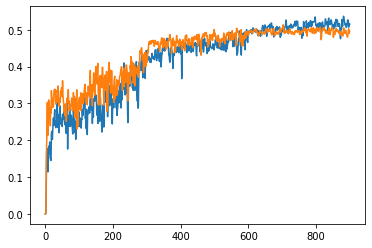

In [7]:
import matplotlib.pyplot as plt
plt.plot(run_dice)
plt.plot(run_val)
unet.cpu()
resnet.cpu()
torch.save({'unet':unet.state_dict(),'resnet':resnet.state_dict()},'AbdomenCTCT_example_complete.pth')